Madusanka Madiligama 01/05/2024

In [1]:

# library imports
import os
import gc
import datetime

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#Configure plot aesthetics for matplotlib and seaborn.
def set_plot_aesthetics():

    plt.rcParams['figure.figsize'] = (10, 8)  
    plt.rcParams['xtick.labelsize'] = 13      
    plt.rcParams['ytick.labelsize'] = 13      
    plt.rcParams['axes.labelsize'] = 14       
    sns.set_palette('Dark2')                  

# Apply the plot settings
set_plot_aesthetics()
colors = list(sns.color_palette('Dark2')) 

In [3]:
#convert date into datetime
def convert_to_date(x):
    return datetime.datetime.strptime(x, '%m/%d/%Y')

In [4]:
# read the CSV file for the electricity consumption
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/electricity_consumption.csv',
                 parse_dates=['Bill_Date'], 
                 date_parser=convert_to_date)
df.head()

C:\Users\nikmb\AppData\Local\Temp\ipykernel_22548\3251922515.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/electricity_consumption.csv',


,Bill_Date,On_peak,Off_peak,Usage_charge,Billed_amount,Billing_days
0,2016-01-01,365,1423.5,219.0,247.73,31
1,2016-02-01,292,1138.8,175.2,234.11,31
2,2016-03-01,130,507.0,78.0,123.85,29
3,2016-04-01,117,456.3,70.2,111.22,29
4,2016-05-01,136,530.4,81.6,118.37,29


In [5]:
#Calculate the number and percentage of missing values in each column of a DataFrame.

def missing_values(df):

    # Calculate the number of missing values per column
    missing_count = df.isnull().sum()

    # Calculate the percentage of missing values
    missing_percent = np.round((100 * missing_count) / len(df), 2)

    # Create a DataFrame to display the results
    missing_data = pd.DataFrame({
        '# Missing': missing_count, 
        '% Missing': missing_percent
    })

    return missing_data


#Prints basic information about the DataFrame, including its size, features, missing values, and unique values count.
def print_data_info(df):

    print(f"Rows: {df.shape[0]}")
    print(f"Columns: {df.shape[1]}")
    print("\nFeatures:")
    print("-" * 10)
    print(df.columns.tolist())
    
    print("\nMissing Values:")
    print("-" * 15)
    print(missing_values(df))
    
    print("\nUnique Values Count:")
    print("-" * 15)
    print(df.nunique())


In [6]:
# printing basic info about the data
print_data_info(df)

Rows: 53
Columns: 6

Features:
----------
['Bill_Date', 'On_peak', 'Off_peak', 'Usage_charge', 'Billed_amount', 'Billing_days']

Missing Values:
---------------
               # Missing  % Missing
Bill_Date              0        0.0
On_peak                0        0.0
Off_peak               0        0.0
Usage_charge           0        0.0
Billed_amount          0        0.0
Billing_days           0        0.0

Unique Values Count:
---------------
Bill_Date        53
On_peak          51
Off_peak         53
Usage_charge     53
Billed_amount    52
Billing_days      9
dtype: int64


In [7]:
# setting the time stamp as the index
bill_df = df.set_index('Bill_Date')
bill_df.head()

,On_peak,Off_peak,Usage_charge,Billed_amount,Billing_days
Bill_Date,,,,,
2016-01-01,365,1423.5,219.0,247.73,31
2016-02-01,292,1138.8,175.2,234.11,31
2016-03-01,130,507.0,78.0,123.85,29
2016-04-01,117,456.3,70.2,111.22,29
2016-05-01,136,530.4,81.6,118.37,29


In [8]:
# checking the column of interest
bill_2018 = bill_df['2016':'2018'][['Billed_amount']]
bill_2018.head()

,Billed_amount
Bill_Date,
2016-01-01,247.73
2016-02-01,234.11
2016-03-01,123.85
2016-04-01,111.22
2016-05-01,118.37


### Simple Moving Average

The simple moving average (SMA) is calculated as the average of a series over a certain period of time. Mathematically, it is represented as:

$$
\frac{1}{n} \sum_{i=0}^{n} t_{i} = \frac{t + (t-1) + (t-2) + \dots + (t-n)}{n}
$$

Where:
- $n$ is the number of periods in the moving average.
- $t_i$ represents each individual value in the series.


In [11]:
#moving average
bill_2018['Billed_amount'].rolling(window=3).mean()
bill_2018['ma_rolling_3'] = bill_2018['Billed_amount'].rolling(window=3).mean().shift(1)
bill_2018.head(5)

,Billed_amount,ma_rolling_3
Bill_Date,,
2016-01-01,247.73,NaN
2016-02-01,234.11,NaN
2016-03-01,123.85,NaN
2016-04-01,111.22,201.896667
2016-05-01,118.37,156.393333


Observing the application of a simple moving average with a time window of 3 and a shift of 1, we find that this method provides reasonable predictions for certain time points. However, it struggles to cope with instances of abrupt increases in the time series data, leading to significant forecast errors. This is indicative of the method's limitations when dealing with non-stationary time series where data points exhibit volatility and large swings.

<Figure size 1000x500 with 0 Axes>

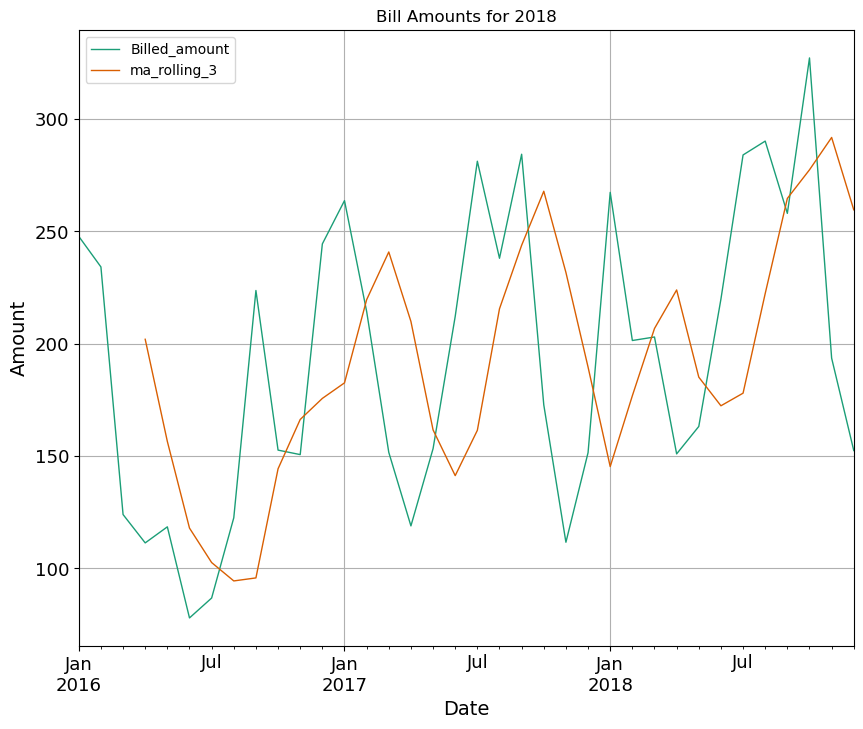

In [14]:
#plot moving averages

plt.figure(figsize=(10, 5))

# Plot each column specifying the label for the legend
bill_2018.plot(linewidth=1, legend=True)


plt.title('Bill Amounts for 2018')
plt.xlabel('Date')
plt.ylabel('Amount')


plt.grid(True)
plt.show()



While there is a noticeable discrepancy between the 'Billed_amount' column and its corresponding 3-period simple moving average 'ma_rolling_3', the simple moving average effectively captures the overall trend and fluctuations in the data. Despite the differences in specific values, this method illustrates its utility in identifying the direction and volatility of the time series.

### Weighted Moving Average

The weighted moving average (WMA) is calculated by multiplying each datum in your series by a weight, and then taking an average of these values. The formula is given by:

$$
\frac{t * w + (t-1) * (w-1) + \ldots + (t-n) * (w-n)}{n}
$$

Where:
- $t$ is the value at time $t$.
- $w$ is the weight assigned to the value at time $t$.
- $n$ is the number of periods over which the average is taken.


In [15]:
# Function to calculate the Weighted Moving Average
def wma(weights):
    def calc(x):
        return (weights * x).sum() / weights.sum()
    return calc


# Define the weights for the WMA
weights = np.array([0.5, 1, 1.5])

# Calculate the WMA for 'Billed_amount' with a rolling window of 3
bill_2018['wma_rolling_3'] = bill_2018['Billed_amount'].rolling(window=len(weights)).apply(wma(weights)).shift(1)


bill_2018.head(10)

,Billed_amount,ma_rolling_3,wma_rolling_3
Bill_Date,,,
2016-01-01,247.73,NaN,NaN
2016-02-01,234.11,NaN,NaN
2016-03-01,123.85,NaN,NaN
2016-04-01,111.22,201.896667,181.250000
2016-05-01,118.37,156.393333,135.911667
2016-06-01,77.81,117.813333,116.900000
2016-07-01,86.67,102.466667,96.898333
2016-08-01,122.40,94.283333,89.000000
2016-09-01,223.62,95.626667,103.058333


<Figure size 1000x500 with 0 Axes>

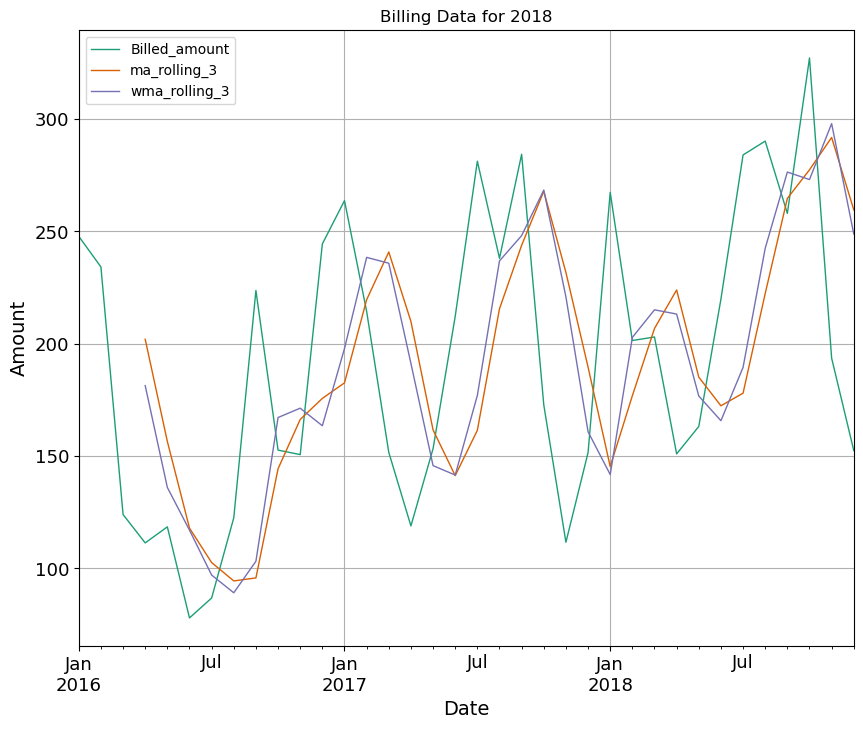

In [18]:
#Plot moving averages
plt.figure(figsize=(10, 5))
bill_2018.plot(linewidth=1)

# Add labels and title
plt.title('Billing Data for 2018')
plt.xlabel('Date')
plt.ylabel('Amount')


plt.grid(True)
plt.show()


### Exponential Moving Average
The Exponential Moving Average (EMA) is a type of moving average that places a greater weight and significance on the most recent data points. The EMA is also referred to as the exponentially weighted moving average.

$$
EMA_t = \left( V_t \times \left( \frac{s}{1 + d} \right) \right) + EMA_{t-1} \times \left(1 - \frac{s}{1 + d}\right)
$$

Where:
- $EMA_t$ is the Exponential Moving Average at time $t$.
- $V_t$ is the value at time $t$.
- $s$ is the smoothing factor.
- $d$ is the number of days.



In [19]:
# Calculate the Exponential Weighted Moving Average with a span of 3

bill_2018['ewm_window_3'] = bill_2018['Billed_amount'].ewm(span=3, adjust=False, min_periods=0).mean()
bill_2018.head(10)

,Billed_amount,ma_rolling_3,wma_rolling_3,ewm_window_3
Bill_Date,,,,
2016-01-01,247.73,NaN,NaN,247.730000
2016-02-01,234.11,NaN,NaN,240.920000
2016-03-01,123.85,NaN,NaN,182.385000
2016-04-01,111.22,201.896667,181.250000,146.802500
2016-05-01,118.37,156.393333,135.911667,132.586250
2016-06-01,77.81,117.813333,116.900000,105.198125
2016-07-01,86.67,102.466667,96.898333,95.934063
2016-08-01,122.40,94.283333,89.000000,109.167031
2016-09-01,223.62,95.626667,103.058333,166.393516


<Figure size 1000x500 with 0 Axes>

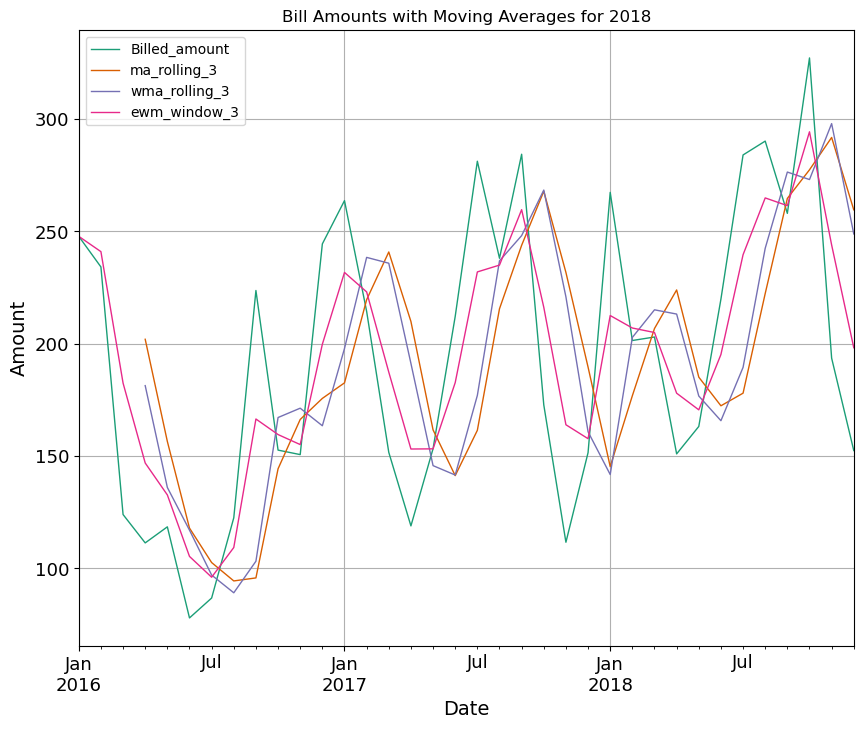

In [22]:
#plot moving averages
plt.figure(figsize=(10, 5))
bill_2018[['Billed_amount', 'ma_rolling_3', 'wma_rolling_3','ewm_window_3']].plot(lw=1)

# Set the title and labels
plt.title('Bill Amounts with Moving Averages for 2018')
plt.xlabel('Date')
plt.ylabel('Amount')

plt.grid(True)
plt.show()

### Exponential Smoothing

Exponential smoothing is a rule of thumb technique for smoothing time series data using the exponential window function. In this method, we can control how much weight is given to past observations versus more recent ones through the smoothing factor $\alpha$ (alpha). A lower alpha places more weight on past data, leading to a smoother curve, but it may increase the lag in response to recent changes, resulting in larger errors when predicting future values. Conversely, a higher alpha gives more weight to recent observations, making the smoothed estimate more responsive to new changes.

The formula for simple exponential smoothing is given by:

$$
S_t = \alpha \cdot Y_t + (1 - \alpha) \cdot S_{t-1}
$$

Where:
- $S_t$ is the smoothed statistic, the forecast for the next period
- $Y_t$ is the actual value at time $t$
- $S_{t-1}$ is the value of the smoothed statistic in the previous period
- $\alpha$ is the smoothing factor, with $0 < \alpha < 1$


In [23]:

# Set the alpha parameter for exponential smoothing
alpha = 0.7

# Calculate the Exponential Smoothing Moving Average with a specified alpha and apply a shift if this is intended to represent a forecast
bill_2018['esm_window_3_7'] = bill_2018['Billed_amount'].ewm(alpha=alpha, adjust=False, min_periods=3).mean().shift(1)

bill_2018.head(10)


,Billed_amount,ma_rolling_3,wma_rolling_3,ewm_window_3,esm_window_3_7
Bill_Date,,,,,
2016-01-01,247.73,NaN,NaN,247.730000,NaN
2016-02-01,234.11,NaN,NaN,240.920000,NaN
2016-03-01,123.85,NaN,NaN,182.385000,NaN
2016-04-01,111.22,201.896667,181.250000,146.802500,158.153800
2016-05-01,118.37,156.393333,135.911667,132.586250,125.300140
2016-06-01,77.81,117.813333,116.900000,105.198125,120.449042
2016-07-01,86.67,102.466667,96.898333,95.934063,90.601713
2016-08-01,122.40,94.283333,89.000000,109.167031,87.849514
2016-09-01,223.62,95.626667,103.058333,166.393516,112.034854


<Figure size 1000x500 with 0 Axes>

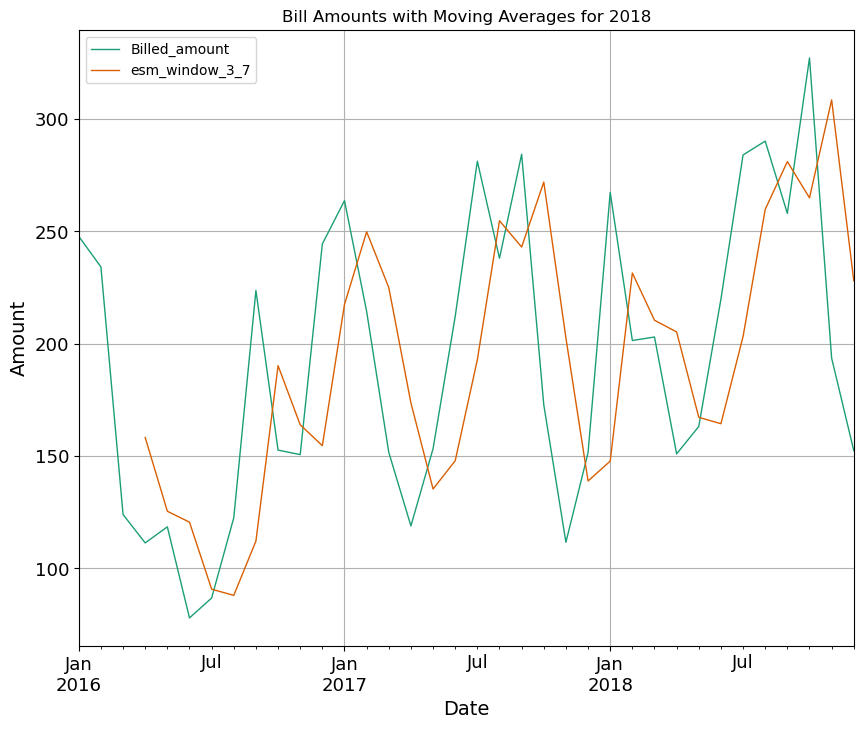

In [24]:
#plot moving averages
plt.figure(figsize=(10, 5))
bill_2018[['Billed_amount', 'esm_window_3_7']].plot(lw=1)

# Set the title and labels
plt.title('Bill Amounts with Moving Averages for 2018')
plt.xlabel('Date')
plt.ylabel('Amount')

plt.grid(True)
plt.show()

In [26]:
bill_2018['esm_window_3_3'] = bill_2018['Billed_amount'].ewm(alpha=0.3, adjust=False, min_periods=3).mean().shift(1)
bill_2018.head(10)

,Billed_amount,ma_rolling_3,wma_rolling_3,ewm_window_3,esm_window_3_7,esm_window_3_3
Bill_Date,,,,,,
2016-01-01,247.73,NaN,NaN,247.730000,NaN,NaN
2016-02-01,234.11,NaN,NaN,240.920000,NaN,NaN
2016-03-01,123.85,NaN,NaN,182.385000,NaN,NaN
2016-04-01,111.22,201.896667,181.250000,146.802500,158.153800,207.705800
2016-05-01,118.37,156.393333,135.911667,132.586250,125.300140,178.760060
2016-06-01,77.81,117.813333,116.900000,105.198125,120.449042,160.643042
2016-07-01,86.67,102.466667,96.898333,95.934063,90.601713,135.793129
2016-08-01,122.40,94.283333,89.000000,109.167031,87.849514,121.056191
2016-09-01,223.62,95.626667,103.058333,166.393516,112.034854,121.459333


<Figure size 1000x500 with 0 Axes>

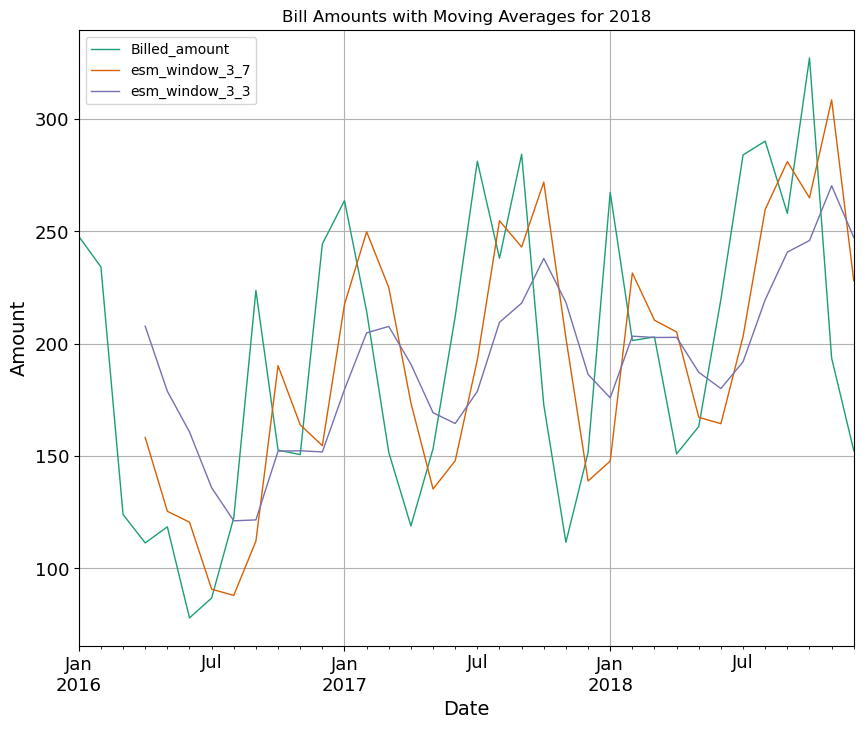

In [27]:
#plot moving averages
plt.figure(figsize=(10, 5))
bill_2018[['Billed_amount', 'esm_window_3_7','esm_window_3_3']].plot(lw=1)

# Set the title and labels
plt.title('Bill Amounts with Moving Averages for 2018')
plt.xlabel('Date')
plt.ylabel('Amount')

plt.grid(True)
plt.show()

To evaluate the performance of various moving average methods, we will compare their respective Root Mean Squared Error (RMSE) values. RMSE provides a measure of the differences between values predicted by a model and the actual values observed. Lower RMSE values indicate a better fit to the observed data. This metric will help us determine which moving average approach yields the most accurate forecasts.

In [28]:
# function to calculate RMSE
def RMSE(col1, col2):
    return np.sqrt(np.mean((col1 - col2)**2))

In [29]:
RMSE(bill_2018['Billed_amount'], bill_2018['ma_rolling_3'])

70.98561687433802

In [30]:

RMSE(bill_2018['Billed_amount'], bill_2018['wma_rolling_3'])

65.82572602256133

In [31]:

RMSE(bill_2018['Billed_amount'], bill_2018['ewm_window_3'])

31.710834656453756

In [32]:

RMSE(bill_2018['Billed_amount'], bill_2018['esm_window_3_7'])

61.26408398853503

In [33]:

RMSE(bill_2018['Billed_amount'], bill_2018['esm_window_3_3'])

65.22424423118377